In [25]:
from __future__ import print_function
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pdb

In [0]:
class TrainTestUtils(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []
        self.misclassifiedImages = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = TrainTestUtils.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations normal
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_train_transforms_rotaion(mean=0.1307, std=0.3081):
        # Train Phase transformations with rotation
        train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean,), (std,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = TrainTestUtils.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = TrainTestUtils.get_train_transforms_rotaion()
        if test_transforms is None:
            test_transforms = TrainTestUtils.get_test_transforms()
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    
    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch, l1_factor=None):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #pdb.set_trace()
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #update l1 regularizer if requested
        if l1_factor:
          loss = self.apply_l1_regularizer(loss, model, l1_factor)

        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        self.misclassifiedImages = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                target_change = target.view_as(pred)
                for i in range(len(pred)):
                  if pred[i].item()!= target_change[i].item():
                    self.misclassifiedImages.append([data[i], pred[i], target_change[i]])
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)
        print("Number of miscalssified Images = ",len(self.misclassifiedImages))

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model, EPOCHS=20, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None, l1_factor=None):
        # Train and test our model
        if optimizer is None:
            optimizer = self.get_optimizer(model, lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch, l1_factor=l1_factor)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff


    def get_optimizer(self, model, lr=0.01, momentum=0.9):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        return optimizer

    def get_step_optimizer(self, model, lr=0.01, momentum=0.9, step_size=1, gamma=0.1):
       optimizer = self.get_optimizer(model, lr, momentum)
       scheduler = StepLR(optimizer, step_size, gamma)
       return optimizer

    def apply_l1_regularizer(self, loss, model, l1_factor=0.0005):
        l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0
        parameters = model.parameters()
        for param in parameters:
          # reg_loss += torch.sum(param.abs())
          zero_vector = torch.rand_like(param) * 0
          reg_loss += l1_crit(param, zero_vector)
        loss += l1_factor * reg_loss
        return loss

    def apply_l2_regularizer(self, model, weight_decay, lr=0.01, momentum=0.9):
        l2_regularizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        return l2_regularizer

    
    def plot_misclassified(self, misclassifiedImages):
      fig = plt.figure(figsize = (10,10))
      for i in range(25):
        sub = fig.add_subplot(5, 5, i+1)
        plt.imshow(misclassifiedImages[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
        sub.set_title("Pred={}, Act={}".format(str(misclassifiedImages[i][1].data.cpu().numpy()),str(misclassifiedImages[i][2].data.cpu().numpy())))       
      plt.tight_layout()
      plt.show()

    def plot_test_loss_acc(self,test_losses,test_acc):
      fig, axs = plt.subplots(1,2,figsize=(15,10))
      axs[0].plot(test_losses)
      axs[0].set_title("Test Loss")
      axs[1].plot(test_acc)
      axs[1].set_title("Test Accuracy")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            pass

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def norm2d(output_channels, batch_type="BN"):
    if batch_type == "GBN":
        num_splits = 2
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

In [0]:
dropout_value = 0.06

class Net(nn.Module):
    def __init__(self, batch_type="BN"):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), # output_size = 26
            
        )
      
        self.convblock2 = nn.Sequential(
            
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), #output_size = 24
            
        )
    
        self.convblock3 = nn.Sequential(
            
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), #output_size = 22
            
        )

        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 11


        self.convblock4 = nn.Sequential(
          

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value), # output_size = 9   
        )

        

        self.convblock5 = nn.Sequential(   
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), bias=False), 
            nn.ReLU(),
            # nn.BatchNorm2d(12),
            norm2d(12, batch_type),
            nn.Dropout(dropout_value),  # output_size = 7     
            
        )

        self.convblock6 = nn.Sequential(   
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), bias=False), 
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.Dropout(dropout_value),   # output_size = 5     
            
        )

        self.convblock7 = nn.Sequential(   
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding = 1,bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            norm2d(16, batch_type),
            nn.Dropout(dropout_value),       # output_size = 5  
            
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) # output_size = 1*1*16
        ) 


        self.convblock8 = nn.Sequential(   
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1),bias=False), # output_size = 1 * 1* 10
                      
        )




    def forward(self, x):


        x = self.convblock1(x)   
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#BN WITHOUT L1L2
bn_test_without_L1L2_Loss = []
bn_test_without_L1L2_acc = []
bn_misclassifiedwithoutL1L2= []

#BN WITH L1
bn_test_with_L1_Loss = []
bn_test_with_L1_acc = []
bn_misclassifiedL1 = []

#BN WITH L2
bn_test_with_L2_Loss = []
bn_test_with_L2_acc = []
bn_misclassifiedL2 = []

#BN WITH L1L2
bn_test_with_L1L2_Loss = []
bn_test_with_L1L2_acc = []
bn_misclassifiedL1L2 = []

#GBN WITHOUT L1L2
gbn_test_without_L1L2_Loss = []
gbn_test_without_L1L2_acc = []
gbn_misclassifiedwithoutL1L2 = []

#GBN WITH L1
gbn_test_with_L1_Loss = []
gbn_test_with_L1_acc = []
gbn_misclassifiedL1 = []

#GBN WITH L2
gbn_test_with_L2_Loss = []
gbn_test_with_L2_acc = []
gbn_misclassifiedL2 = []

#GBN WITH L1L2
gbn_test_with_L1L2_Loss = []
gbn_test_with_L1L2_acc = []
gbn_misclassifiedL1L2 = []

EPOCHS = 25
GBN_BATCHSIZE = 64
BN_BATCHSIZE = 32

**GHOST BATCH NORMALISATION**

**GBN WITHOUT L1L2 Loss**

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
    GhostBatchNorm-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
    GhostBatchNorm-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
   GhostBatchNorm-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.1757371723651886 Batch_id=937 Accuracy=92.13: 100%|██████████| 938/938 [00:30<00:00, 31.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  194

Test set: Average loss: 0.0650, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


Train Set: Train Loss=0.06717358529567719 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:30<00:00, 31.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  110

Test set: Average loss: 0.0358, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Train Set: Train Loss=0.03200127184391022 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:30<00:00, 31.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  100

Test set: Average loss: 0.0344, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Train Set: Train Loss=0.021082863211631775 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:30<00:00, 30.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  95

Test set: Average loss: 0.0323, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Train Set: Train Loss=0.02606235444545746 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  86

Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Train Set: Train Loss=0.12717527151107788 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:31<00:00, 30.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  85

Test set: Average loss: 0.0253, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Train Set: Train Loss=0.1676596701145172 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:30<00:00, 30.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Train Set: Train Loss=0.030473262071609497 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:30<00:00, 31.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Train Set: Train Loss=0.086562380194664 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:30<00:00, 31.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0231, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Train Set: Train Loss=0.01663312315940857 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:30<00:00, 31.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  71

Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Train Set: Train Loss=0.006741136312484741 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:30<00:00, 31.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  63

Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Train Set: Train Loss=0.06507943570613861 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:30<00:00, 31.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Train Set: Train Loss=0.05478397011756897 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:30<00:00, 31.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  59

Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Train Set: Train Loss=0.3810729384422302 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:30<00:00, 31.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Train Set: Train Loss=0.04264645278453827 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:30<00:00, 31.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  55

Test set: Average loss: 0.0216, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Train Set: Train Loss=0.004827365279197693 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:29<00:00, 31.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  51

Test set: Average loss: 0.0190, Accuracy: 9949/10000 (99.49%)

EPOCH: 17


Train Set: Train Loss=0.07782256603240967 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:30<00:00, 31.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  53

Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Train Set: Train Loss=0.003964945673942566 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:30<00:00, 30.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  56

Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Train Set: Train Loss=0.022712677717208862 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:30<00:00, 30.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  62

Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Train Set: Train Loss=0.062154799699783325 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:30<00:00, 30.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Train Set: Train Loss=0.020429715514183044 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:30<00:00, 30.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  67

Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Train Set: Train Loss=0.016540393233299255 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:30<00:00, 30.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Train Set: Train Loss=0.14196635782718658 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:30<00:00, 30.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  52

Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Train Set: Train Loss=0.0015021264553070068 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:30<00:00, 30.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Train Set: Train Loss=0.011971846222877502 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:30<00:00, 30.29it/s]


Number of miscalssified Images =  64

Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)



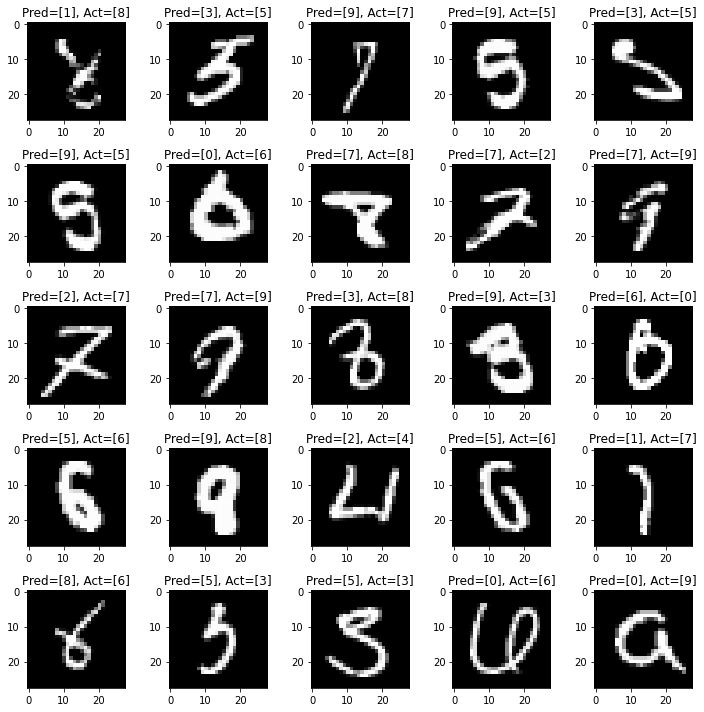

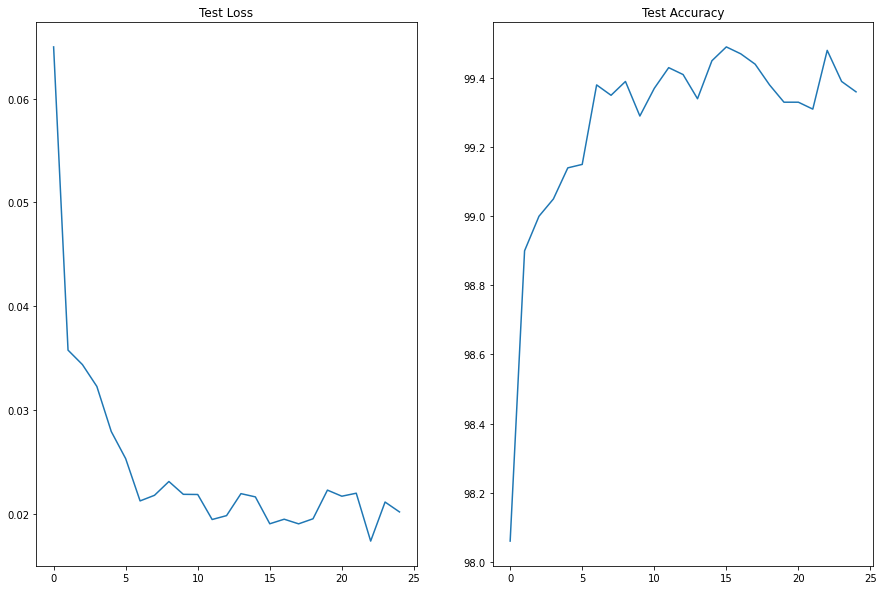

In [32]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE)

    gbn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_without_L1L2_Loss, gbn_test_without_L1L2_acc)

**GBN With L1 Loss**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.4015480875968933 Batch_id=937 Accuracy=91.16: 100%|██████████| 938/938 [00:37<00:00, 24.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  172

Test set: Average loss: 0.0566, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Train Set: Train Loss=0.3244655728340149 Batch_id=937 Accuracy=97.05: 100%|██████████| 938/938 [00:37<00:00, 24.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0535, Accuracy: 9844/10000 (98.44%)

EPOCH: 3


Train Set: Train Loss=0.22409270703792572 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:37<00:00, 25.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  165

Test set: Average loss: 0.0600, Accuracy: 9835/10000 (98.35%)

EPOCH: 4


Train Set: Train Loss=0.3049350082874298 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:37<00:00, 24.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0484, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Train Set: Train Loss=0.26922693848609924 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0436, Accuracy: 9869/10000 (98.69%)

EPOCH: 6


Train Set: Train Loss=0.26803168654441833 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:37<00:00, 25.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  171

Test set: Average loss: 0.0546, Accuracy: 9829/10000 (98.29%)

EPOCH: 7


Train Set: Train Loss=0.3648330569267273 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:37<00:00, 25.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0401, Accuracy: 9870/10000 (98.70%)

EPOCH: 8


Train Set: Train Loss=0.38273513317108154 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:37<00:00, 24.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0450, Accuracy: 9854/10000 (98.54%)

EPOCH: 9


Train Set: Train Loss=0.33609771728515625 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  142

Test set: Average loss: 0.0464, Accuracy: 9858/10000 (98.58%)

EPOCH: 10


Train Set: Train Loss=0.33908528089523315 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:37<00:00, 25.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0410, Accuracy: 9868/10000 (98.68%)

EPOCH: 11


Train Set: Train Loss=0.2123938500881195 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0445, Accuracy: 9866/10000 (98.66%)

EPOCH: 12


Train Set: Train Loss=0.3570759892463684 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:37<00:00, 24.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  130

Test set: Average loss: 0.0386, Accuracy: 9870/10000 (98.70%)

EPOCH: 13


Train Set: Train Loss=0.24415510892868042 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:38<00:00, 24.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  102

Test set: Average loss: 0.0349, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Train Set: Train Loss=0.6152331829071045 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  172

Test set: Average loss: 0.0506, Accuracy: 9828/10000 (98.28%)

EPOCH: 15


Train Set: Train Loss=0.2627689242362976 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0437, Accuracy: 9866/10000 (98.66%)

EPOCH: 16


Train Set: Train Loss=0.23701560497283936 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:37<00:00, 25.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0449, Accuracy: 9857/10000 (98.57%)

EPOCH: 17


Train Set: Train Loss=0.20507997274398804 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:37<00:00, 25.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0496, Accuracy: 9844/10000 (98.44%)

EPOCH: 18


Train Set: Train Loss=0.21727322041988373 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:37<00:00, 25.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  120

Test set: Average loss: 0.0417, Accuracy: 9880/10000 (98.80%)

EPOCH: 19


Train Set: Train Loss=0.2011534571647644 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:37<00:00, 24.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0449, Accuracy: 9868/10000 (98.68%)

EPOCH: 20


Train Set: Train Loss=0.22005115449428558 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:37<00:00, 25.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0493, Accuracy: 9839/10000 (98.39%)

EPOCH: 21


Train Set: Train Loss=0.2741798460483551 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:37<00:00, 24.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  175

Test set: Average loss: 0.0609, Accuracy: 9825/10000 (98.25%)

EPOCH: 22


Train Set: Train Loss=0.20411916077136993 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:37<00:00, 24.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  122

Test set: Average loss: 0.0378, Accuracy: 9878/10000 (98.78%)

EPOCH: 23


Train Set: Train Loss=0.18483498692512512 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:37<00:00, 24.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0399, Accuracy: 9871/10000 (98.71%)

EPOCH: 24


Train Set: Train Loss=0.21242891252040863 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  156

Test set: Average loss: 0.0473, Accuracy: 9844/10000 (98.44%)

EPOCH: 25


Train Set: Train Loss=0.424031138420105 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:37<00:00, 25.02it/s]


Number of miscalssified Images =  108

Test set: Average loss: 0.0377, Accuracy: 9892/10000 (98.92%)



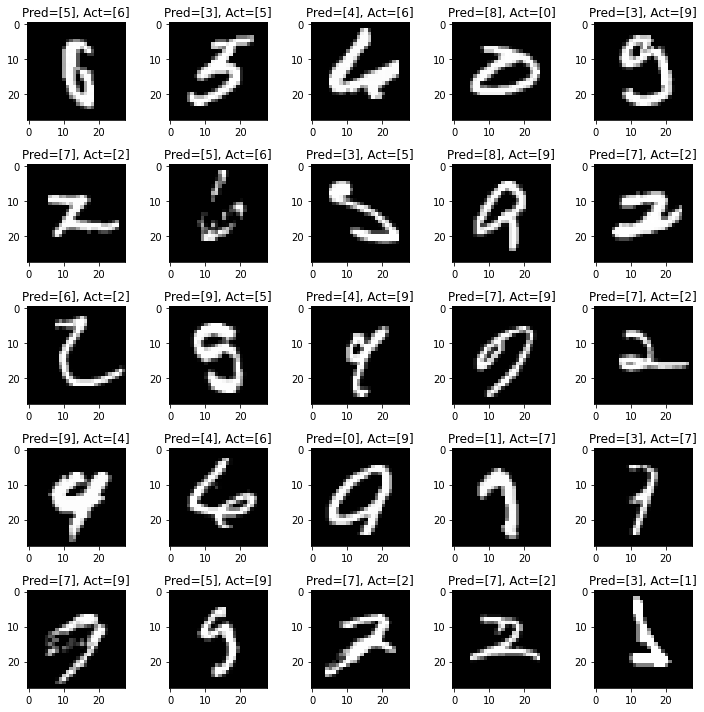

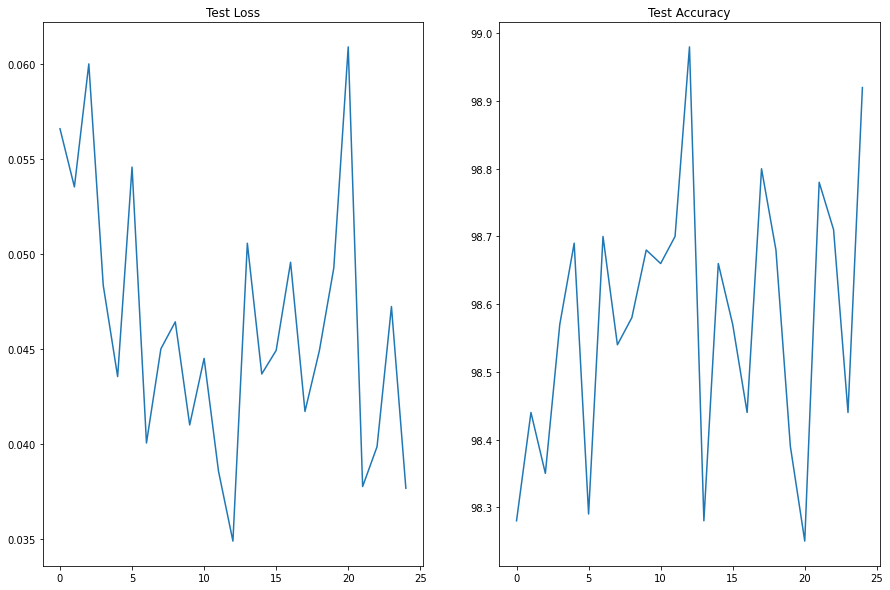

In [33]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005)

    gbn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL1)

    gbn_test_with_L1_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1_Loss, gbn_test_with_L1_acc)

**GBN WITH L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.09619595110416412 Batch_id=937 Accuracy=91.17: 100%|██████████| 938/938 [00:30<00:00, 30.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  165

Test set: Average loss: 0.0642, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Train Set: Train Loss=0.10938622802495956 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:31<00:00, 29.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0561, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Train Set: Train Loss=0.05382449924945831 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:31<00:00, 29.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0619, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Train Set: Train Loss=0.0611514076590538 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:31<00:00, 30.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0580, Accuracy: 9850/10000 (98.50%)

EPOCH: 5


Train Set: Train Loss=0.11783692240715027 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:31<00:00, 30.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  155

Test set: Average loss: 0.0609, Accuracy: 9845/10000 (98.45%)

EPOCH: 6


Train Set: Train Loss=0.12680964171886444 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:30<00:00, 30.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  127

Test set: Average loss: 0.0585, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Train Set: Train Loss=0.31889352202415466 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:30<00:00, 30.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0539, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


Train Set: Train Loss=0.17249026894569397 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:30<00:00, 30.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  228

Test set: Average loss: 0.0949, Accuracy: 9772/10000 (97.72%)

EPOCH: 9


Train Set: Train Loss=0.10046256333589554 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:30<00:00, 30.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  134

Test set: Average loss: 0.0570, Accuracy: 9866/10000 (98.66%)

EPOCH: 10


Train Set: Train Loss=0.08232840895652771 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:30<00:00, 30.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0645, Accuracy: 9849/10000 (98.49%)

EPOCH: 11


Train Set: Train Loss=0.036741770803928375 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:30<00:00, 30.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0593, Accuracy: 9863/10000 (98.63%)

EPOCH: 12


Train Set: Train Loss=0.15003465116024017 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:30<00:00, 30.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  111

Test set: Average loss: 0.0521, Accuracy: 9889/10000 (98.89%)

EPOCH: 13


Train Set: Train Loss=0.11006861925125122 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:30<00:00, 30.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0535, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Train Set: Train Loss=0.5323585271835327 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:30<00:00, 30.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0693, Accuracy: 9814/10000 (98.14%)

EPOCH: 15


Train Set: Train Loss=0.05735323578119278 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:30<00:00, 30.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  113

Test set: Average loss: 0.0481, Accuracy: 9887/10000 (98.87%)

EPOCH: 16


Train Set: Train Loss=0.06285673379898071 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:30<00:00, 30.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  113

Test set: Average loss: 0.0534, Accuracy: 9887/10000 (98.87%)

EPOCH: 17


Train Set: Train Loss=0.0950484648346901 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:30<00:00, 30.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  90

Test set: Average loss: 0.0460, Accuracy: 9910/10000 (99.10%)

EPOCH: 18


Train Set: Train Loss=0.0616617426276207 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:30<00:00, 30.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  157

Test set: Average loss: 0.0638, Accuracy: 9843/10000 (98.43%)

EPOCH: 19


Train Set: Train Loss=0.07926134765148163 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:31<00:00, 30.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  119

Test set: Average loss: 0.0596, Accuracy: 9881/10000 (98.81%)

EPOCH: 20


Train Set: Train Loss=0.0902293249964714 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:31<00:00, 29.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  151

Test set: Average loss: 0.0579, Accuracy: 9849/10000 (98.49%)

EPOCH: 21


Train Set: Train Loss=0.14199715852737427 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:31<00:00, 29.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  150

Test set: Average loss: 0.0638, Accuracy: 9850/10000 (98.50%)

EPOCH: 22


Train Set: Train Loss=0.09813715517520905 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:31<00:00, 29.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  115

Test set: Average loss: 0.0582, Accuracy: 9885/10000 (98.85%)

EPOCH: 23


Train Set: Train Loss=0.04863137751817703 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:31<00:00, 29.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  84

Test set: Average loss: 0.0409, Accuracy: 9916/10000 (99.16%)

EPOCH: 24


Train Set: Train Loss=0.13117453455924988 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:31<00:00, 30.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0624, Accuracy: 9834/10000 (98.34%)

EPOCH: 25


Train Set: Train Loss=0.11184735596179962 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:30<00:00, 30.31it/s]


Number of miscalssified Images =  167

Test set: Average loss: 0.0663, Accuracy: 9833/10000 (98.33%)



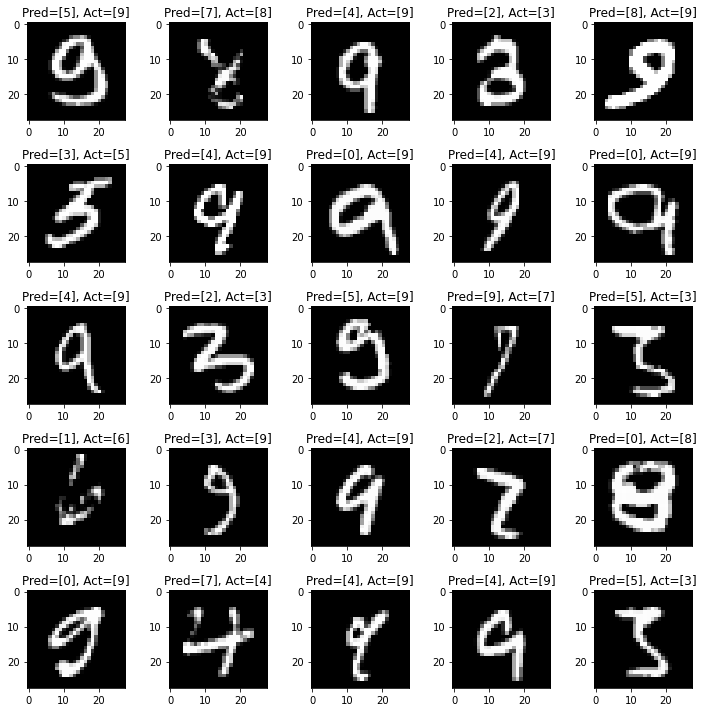

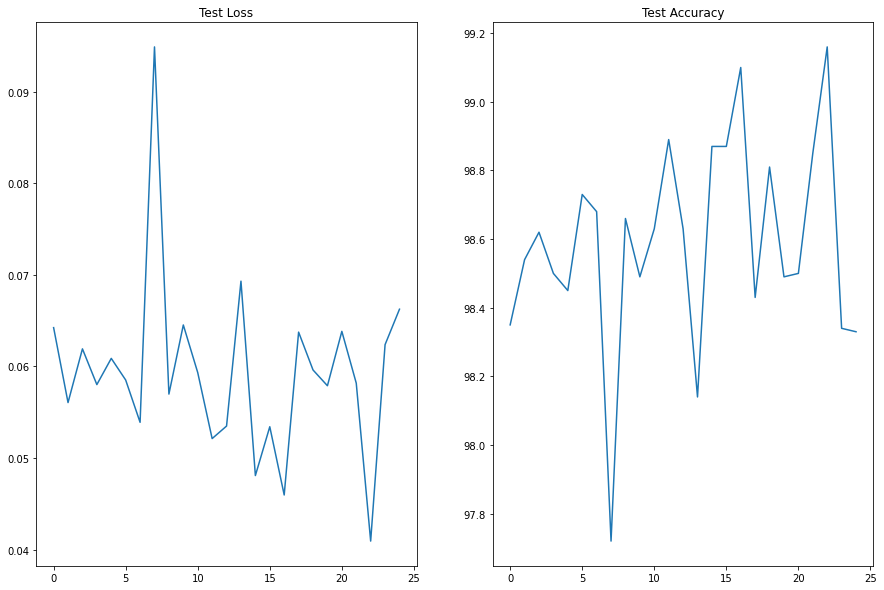

In [34]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, optimizer=l2_regulizer)

    gbn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedL2)

    gbn_test_with_L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L2_Loss, gbn_test_with_L2_acc)

**GBN WITH L1L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.3373100757598877 Batch_id=937 Accuracy=91.17: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  225

Test set: Average loss: 0.0820, Accuracy: 9775/10000 (97.75%)

EPOCH: 2


Train Set: Train Loss=0.2726815938949585 Batch_id=937 Accuracy=96.84: 100%|██████████| 938/938 [00:38<00:00, 24.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  205

Test set: Average loss: 0.0740, Accuracy: 9795/10000 (97.95%)

EPOCH: 3


Train Set: Train Loss=0.2656667232513428 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [00:38<00:00, 24.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  183

Test set: Average loss: 0.0828, Accuracy: 9817/10000 (98.17%)

EPOCH: 4


Train Set: Train Loss=0.20641133189201355 Batch_id=937 Accuracy=97.02: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  340

Test set: Average loss: 0.1256, Accuracy: 9660/10000 (96.60%)

EPOCH: 5


Train Set: Train Loss=0.28493940830230713 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:38<00:00, 24.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  183

Test set: Average loss: 0.0746, Accuracy: 9817/10000 (98.17%)

EPOCH: 6


Train Set: Train Loss=0.2171439379453659 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:38<00:00, 24.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  270

Test set: Average loss: 0.1086, Accuracy: 9730/10000 (97.30%)

EPOCH: 7


Train Set: Train Loss=0.40905851125717163 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:38<00:00, 24.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  206

Test set: Average loss: 0.0894, Accuracy: 9794/10000 (97.94%)

EPOCH: 8


Train Set: Train Loss=0.2708946466445923 Batch_id=937 Accuracy=97.20: 100%|██████████| 938/938 [00:38<00:00, 24.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  228

Test set: Average loss: 0.0907, Accuracy: 9772/10000 (97.72%)

EPOCH: 9


Train Set: Train Loss=0.23688578605651855 Batch_id=937 Accuracy=97.16: 100%|██████████| 938/938 [00:38<00:00, 24.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0600, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Train Set: Train Loss=0.263704776763916 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:38<00:00, 24.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  198

Test set: Average loss: 0.0755, Accuracy: 9802/10000 (98.02%)

EPOCH: 11


Train Set: Train Loss=0.23653045296669006 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:39<00:00, 23.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  245

Test set: Average loss: 0.0927, Accuracy: 9755/10000 (97.55%)

EPOCH: 12


Train Set: Train Loss=0.45112454891204834 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  125

Test set: Average loss: 0.0556, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Train Set: Train Loss=0.3257201313972473 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  138

Test set: Average loss: 0.0615, Accuracy: 9862/10000 (98.62%)

EPOCH: 14


Train Set: Train Loss=0.6931316256523132 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:37<00:00, 24.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  274

Test set: Average loss: 0.1028, Accuracy: 9726/10000 (97.26%)

EPOCH: 15


Train Set: Train Loss=0.2920096218585968 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:37<00:00, 24.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  247

Test set: Average loss: 0.0974, Accuracy: 9753/10000 (97.53%)

EPOCH: 16


Train Set: Train Loss=0.24480149149894714 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  237

Test set: Average loss: 0.0914, Accuracy: 9763/10000 (97.63%)

EPOCH: 17


Train Set: Train Loss=0.35944536328315735 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:37<00:00, 24.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  179

Test set: Average loss: 0.0728, Accuracy: 9821/10000 (98.21%)

EPOCH: 18


Train Set: Train Loss=0.21622905135154724 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [00:37<00:00, 24.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  137

Test set: Average loss: 0.0626, Accuracy: 9863/10000 (98.63%)

EPOCH: 19


Train Set: Train Loss=0.20567497611045837 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:38<00:00, 24.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0845, Accuracy: 9814/10000 (98.14%)

EPOCH: 20


Train Set: Train Loss=0.27994781732559204 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:37<00:00, 24.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  195

Test set: Average loss: 0.0750, Accuracy: 9805/10000 (98.05%)

EPOCH: 21


Train Set: Train Loss=0.32754361629486084 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:38<00:00, 24.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  160

Test set: Average loss: 0.0667, Accuracy: 9840/10000 (98.40%)

EPOCH: 22


Train Set: Train Loss=0.22953751683235168 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:38<00:00, 24.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  177

Test set: Average loss: 0.0727, Accuracy: 9823/10000 (98.23%)

EPOCH: 23


Train Set: Train Loss=0.26545441150665283 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:38<00:00, 24.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  155

Test set: Average loss: 0.0647, Accuracy: 9845/10000 (98.45%)

EPOCH: 24


Train Set: Train Loss=0.2705520987510681 Batch_id=937 Accuracy=97.19: 100%|██████████| 938/938 [00:37<00:00, 24.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of miscalssified Images =  230

Test set: Average loss: 0.0970, Accuracy: 9770/10000 (97.70%)

EPOCH: 25


Train Set: Train Loss=0.2551678419113159 Batch_id=937 Accuracy=97.19: 100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


Number of miscalssified Images =  144

Test set: Average loss: 0.0670, Accuracy: 9856/10000 (98.56%)



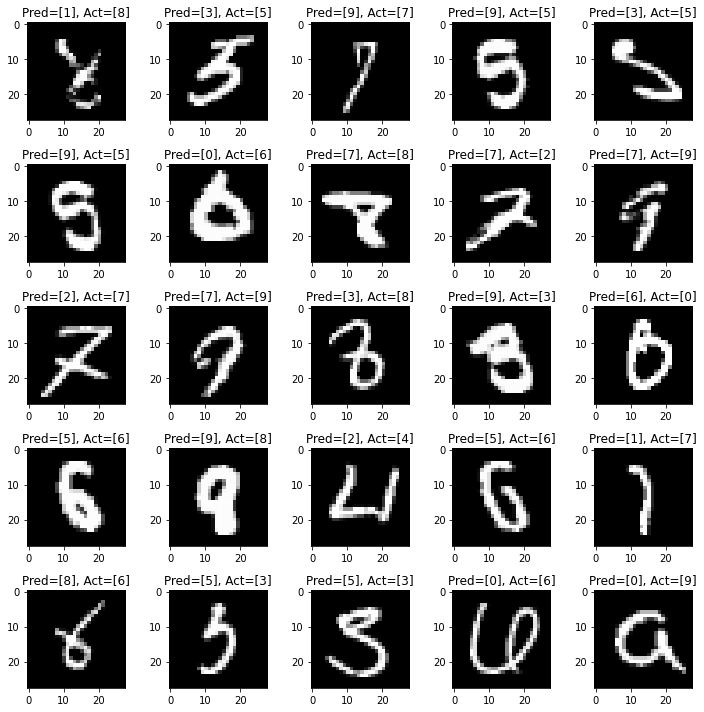

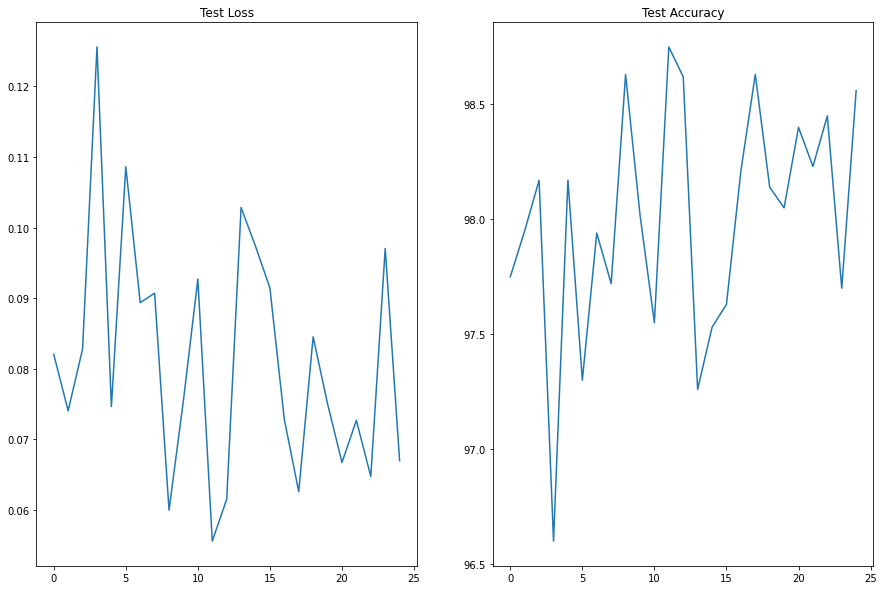

In [35]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net(batch_type="GBN")
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=GBN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    gbn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(gbn_misclassifiedwithoutL1L2)

    gbn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    gbn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(gbn_test_with_L1L2_Loss, gbn_test_with_L1L2_acc)

**BATCH NORMALISATION**

**BN WITHOUT L1L2**

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,296
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.13619160652160645 Batch_id=1874 Accuracy=93.61: 100%|██████████| 1875/1875 [00:48<00:00, 38.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  119

Test set: Average loss: 0.0380, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Train Set: Train Loss=0.06918248534202576 Batch_id=1874 Accuracy=97.80: 100%|██████████| 1875/1875 [00:49<00:00, 38.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  116

Test set: Average loss: 0.0368, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Train Set: Train Loss=0.01956978440284729 Batch_id=1874 Accuracy=98.27: 100%|██████████| 1875/1875 [00:47<00:00, 39.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  99

Test set: Average loss: 0.0283, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Train Set: Train Loss=0.014785811305046082 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:46<00:00, 39.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  82

Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Train Set: Train Loss=0.03455588221549988 Batch_id=1874 Accuracy=98.56: 100%|██████████| 1875/1875 [00:46<00:00, 40.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 6


Train Set: Train Loss=0.003172650933265686 Batch_id=1874 Accuracy=98.71: 100%|██████████| 1875/1875 [00:47<00:00, 39.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  71

Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Train Set: Train Loss=0.13991396129131317 Batch_id=1874 Accuracy=98.75: 100%|██████████| 1875/1875 [00:47<00:00, 39.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  71

Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Train Set: Train Loss=0.04460936039686203 Batch_id=1874 Accuracy=98.81: 100%|██████████| 1875/1875 [00:47<00:00, 39.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  55

Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

EPOCH: 9


Train Set: Train Loss=0.05086016654968262 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [00:47<00:00, 39.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  70

Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Train Set: Train Loss=0.16275645792484283 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:47<00:00, 39.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Train Set: Train Loss=0.0017250478267669678 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [00:46<00:00, 40.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  65

Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Train Set: Train Loss=0.011269062757492065 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:48<00:00, 38.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Train Set: Train Loss=0.0023212432861328125 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [00:48<00:00, 38.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Train Set: Train Loss=0.03932526707649231 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [00:47<00:00, 39.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  61

Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Train Set: Train Loss=0.1755649596452713 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:46<00:00, 40.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Train Set: Train Loss=0.001107722520828247 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:46<00:00, 39.97it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Train Set: Train Loss=0.018908798694610596 Batch_id=1874 Accuracy=99.10: 100%|██████████| 1875/1875 [00:47<00:00, 39.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  56

Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Train Set: Train Loss=0.006603866815567017 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:47<00:00, 39.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  57

Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Train Set: Train Loss=0.001000717282295227 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [00:47<00:00, 39.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  69

Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Train Set: Train Loss=0.002329424023628235 Batch_id=1874 Accuracy=99.19: 100%|██████████| 1875/1875 [00:47<00:00, 39.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  66

Test set: Average loss: 0.0223, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Train Set: Train Loss=0.07052864134311676 Batch_id=1874 Accuracy=99.16: 100%|██████████| 1875/1875 [00:46<00:00, 39.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  59

Test set: Average loss: 0.0213, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Train Set: Train Loss=0.0208519846200943 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:47<00:00, 39.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  64

Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Train Set: Train Loss=0.0009318292140960693 Batch_id=1874 Accuracy=99.22: 100%|██████████| 1875/1875 [00:47<00:00, 39.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  60

Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Train Set: Train Loss=0.00189131498336792 Batch_id=1874 Accuracy=99.18: 100%|██████████| 1875/1875 [00:48<00:00, 38.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  59

Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Train Set: Train Loss=0.0011005699634552002 Batch_id=1874 Accuracy=99.23: 100%|██████████| 1875/1875 [00:48<00:00, 38.61it/s]


Number of miscalssified Images =  59

Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)



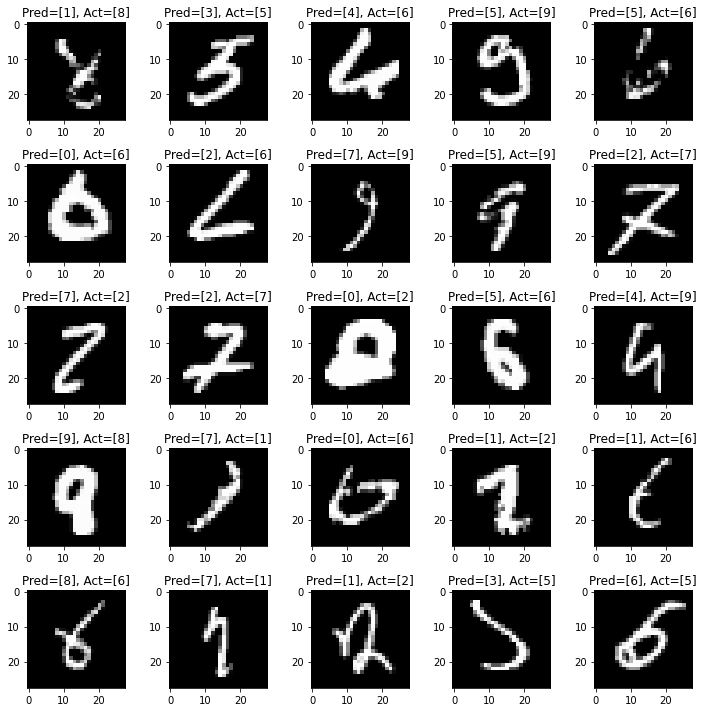

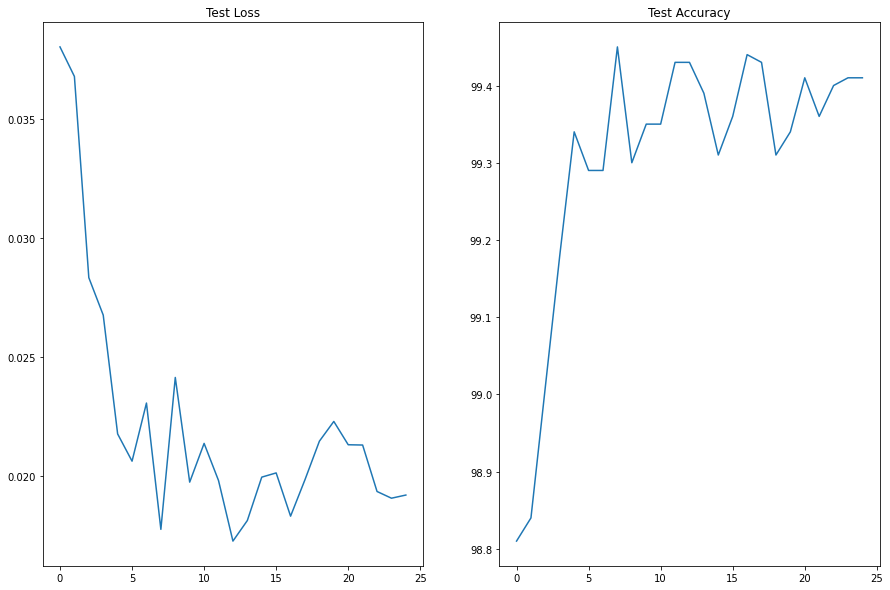

In [36]:
with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE)

    bn_misclassifiedwithoutL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_without_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_without_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_without_L1L2_Loss, bn_test_without_L1L2_acc)

**BN WITH L1**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.3729904294013977 Batch_id=1874 Accuracy=93.20: 100%|██████████| 1875/1875 [01:07<00:00, 27.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  246

Test set: Average loss: 0.0795, Accuracy: 9754/10000 (97.54%)

EPOCH: 2


Train Set: Train Loss=0.36399683356285095 Batch_id=1874 Accuracy=96.78: 100%|██████████| 1875/1875 [01:07<00:00, 27.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  169

Test set: Average loss: 0.0560, Accuracy: 9831/10000 (98.31%)

EPOCH: 3


Train Set: Train Loss=0.2933194041252136 Batch_id=1874 Accuracy=97.08: 100%|██████████| 1875/1875 [01:08<00:00, 27.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  187

Test set: Average loss: 0.0567, Accuracy: 9813/10000 (98.13%)

EPOCH: 4


Train Set: Train Loss=0.22783535718917847 Batch_id=1874 Accuracy=97.10: 100%|██████████| 1875/1875 [01:07<00:00, 27.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  143

Test set: Average loss: 0.0466, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Train Set: Train Loss=0.28418827056884766 Batch_id=1874 Accuracy=97.14: 100%|██████████| 1875/1875 [01:07<00:00, 27.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  152

Test set: Average loss: 0.0452, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Train Set: Train Loss=0.2412680983543396 Batch_id=1874 Accuracy=97.29: 100%|██████████| 1875/1875 [01:07<00:00, 27.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  206

Test set: Average loss: 0.0651, Accuracy: 9794/10000 (97.94%)

EPOCH: 7


Train Set: Train Loss=0.4281665086746216 Batch_id=1874 Accuracy=97.20: 100%|██████████| 1875/1875 [01:07<00:00, 27.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  164

Test set: Average loss: 0.0531, Accuracy: 9836/10000 (98.36%)

EPOCH: 8


Train Set: Train Loss=0.3113099932670593 Batch_id=1874 Accuracy=97.24: 100%|██████████| 1875/1875 [01:08<00:00, 27.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  214

Test set: Average loss: 0.0655, Accuracy: 9786/10000 (97.86%)

EPOCH: 9


Train Set: Train Loss=0.28641751408576965 Batch_id=1874 Accuracy=97.26: 100%|██████████| 1875/1875 [01:08<00:00, 27.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  163

Test set: Average loss: 0.0537, Accuracy: 9837/10000 (98.37%)

EPOCH: 10


Train Set: Train Loss=0.39839839935302734 Batch_id=1874 Accuracy=97.32: 100%|██████████| 1875/1875 [01:07<00:00, 27.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  190

Test set: Average loss: 0.0594, Accuracy: 9810/10000 (98.10%)

EPOCH: 11


Train Set: Train Loss=0.21557466685771942 Batch_id=1874 Accuracy=97.28: 100%|██████████| 1875/1875 [01:07<00:00, 27.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  136

Test set: Average loss: 0.0458, Accuracy: 9864/10000 (98.64%)

EPOCH: 12


Train Set: Train Loss=0.20946407318115234 Batch_id=1874 Accuracy=97.29: 100%|██████████| 1875/1875 [01:07<00:00, 27.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  129

Test set: Average loss: 0.0428, Accuracy: 9871/10000 (98.71%)

EPOCH: 13


Train Set: Train Loss=0.19654981791973114 Batch_id=1874 Accuracy=97.37: 100%|██████████| 1875/1875 [01:07<00:00, 27.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  162

Test set: Average loss: 0.0505, Accuracy: 9838/10000 (98.38%)

EPOCH: 14


Train Set: Train Loss=0.3523678779602051 Batch_id=1874 Accuracy=97.36: 100%|██████████| 1875/1875 [01:07<00:00, 27.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  141

Test set: Average loss: 0.0488, Accuracy: 9859/10000 (98.59%)

EPOCH: 15


Train Set: Train Loss=0.26346084475517273 Batch_id=1874 Accuracy=97.35: 100%|██████████| 1875/1875 [01:07<00:00, 27.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0416, Accuracy: 9869/10000 (98.69%)

EPOCH: 16


Train Set: Train Loss=0.22388891875743866 Batch_id=1874 Accuracy=97.31: 100%|██████████| 1875/1875 [01:08<00:00, 27.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  247

Test set: Average loss: 0.0742, Accuracy: 9753/10000 (97.53%)

EPOCH: 17


Train Set: Train Loss=0.2605767548084259 Batch_id=1874 Accuracy=97.30: 100%|██████████| 1875/1875 [01:08<00:00, 27.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  114

Test set: Average loss: 0.0382, Accuracy: 9886/10000 (98.86%)

EPOCH: 18


Train Set: Train Loss=0.23945282399654388 Batch_id=1874 Accuracy=97.35: 100%|██████████| 1875/1875 [01:07<00:00, 27.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  178

Test set: Average loss: 0.0549, Accuracy: 9822/10000 (98.22%)

EPOCH: 19


Train Set: Train Loss=0.20921187102794647 Batch_id=1874 Accuracy=97.30: 100%|██████████| 1875/1875 [01:07<00:00, 27.86it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  169

Test set: Average loss: 0.0581, Accuracy: 9831/10000 (98.31%)

EPOCH: 20


Train Set: Train Loss=0.2372380793094635 Batch_id=1874 Accuracy=97.34: 100%|██████████| 1875/1875 [01:07<00:00, 27.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  216

Test set: Average loss: 0.0713, Accuracy: 9784/10000 (97.84%)

EPOCH: 21


Train Set: Train Loss=0.31103187799453735 Batch_id=1874 Accuracy=97.30: 100%|██████████| 1875/1875 [01:07<00:00, 27.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  174

Test set: Average loss: 0.0569, Accuracy: 9826/10000 (98.26%)

EPOCH: 22


Train Set: Train Loss=0.26466700434684753 Batch_id=1874 Accuracy=97.34: 100%|██████████| 1875/1875 [01:07<00:00, 27.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  113

Test set: Average loss: 0.0362, Accuracy: 9887/10000 (98.87%)

EPOCH: 23


Train Set: Train Loss=0.19625338912010193 Batch_id=1874 Accuracy=97.40: 100%|██████████| 1875/1875 [01:07<00:00, 27.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  131

Test set: Average loss: 0.0437, Accuracy: 9869/10000 (98.69%)

EPOCH: 24


Train Set: Train Loss=0.2431829273700714 Batch_id=1874 Accuracy=97.45: 100%|██████████| 1875/1875 [01:07<00:00, 27.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  173

Test set: Average loss: 0.0593, Accuracy: 9827/10000 (98.27%)

EPOCH: 25


Train Set: Train Loss=0.3290552794933319 Batch_id=1874 Accuracy=97.47: 100%|██████████| 1875/1875 [01:08<00:00, 27.32it/s]


Number of miscalssified Images =  276

Test set: Average loss: 0.0962, Accuracy: 9724/10000 (97.24%)



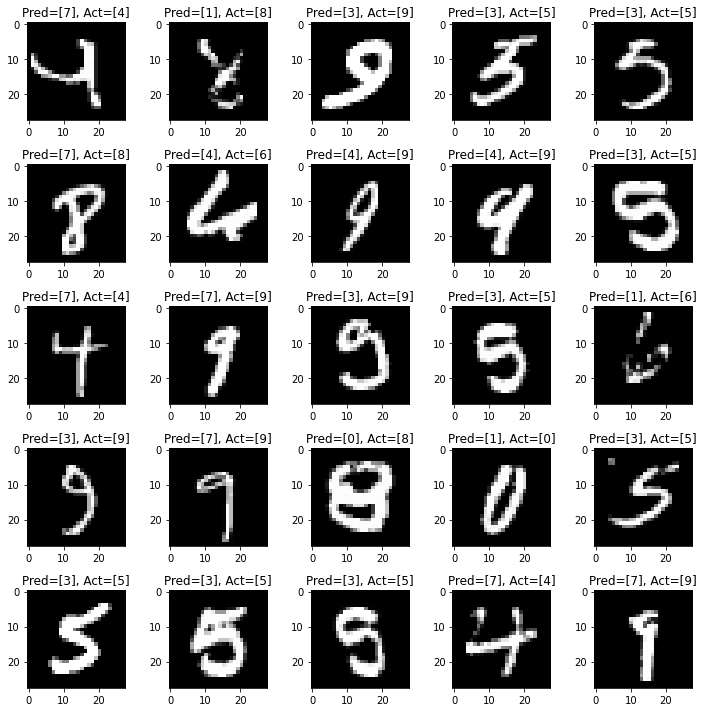

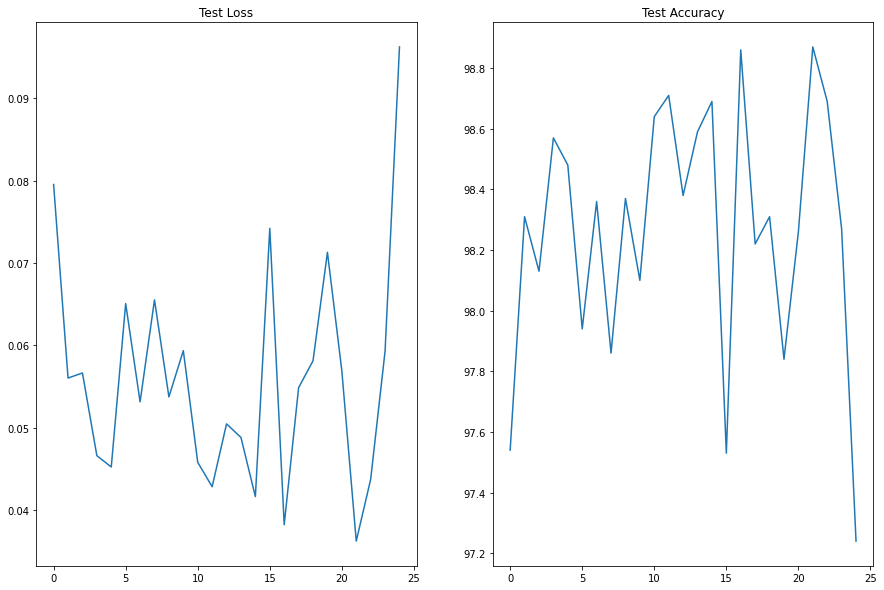

In [37]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005)

    bn_misclassifiedL1.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL1)

    bn_test_with_L1_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1_Loss, bn_test_with_L1_acc)

**BN WITH L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Train Set: Train Loss=0.08165838569402695 Batch_id=1874 Accuracy=93.27: 100%|██████████| 1875/1875 [00:48<00:00, 38.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  235

Test set: Average loss: 0.0861, Accuracy: 9765/10000 (97.65%)

EPOCH: 2


Train Set: Train Loss=0.11859218031167984 Batch_id=1874 Accuracy=97.27: 100%|██████████| 1875/1875 [00:47<00:00, 39.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  209

Test set: Average loss: 0.0800, Accuracy: 9791/10000 (97.91%)

EPOCH: 3


Train Set: Train Loss=0.1966760903596878 Batch_id=1874 Accuracy=97.47: 100%|██████████| 1875/1875 [00:47<00:00, 39.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  192

Test set: Average loss: 0.0812, Accuracy: 9808/10000 (98.08%)

EPOCH: 4


Train Set: Train Loss=0.03082619607448578 Batch_id=1874 Accuracy=97.38: 100%|██████████| 1875/1875 [00:47<00:00, 39.65it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  195

Test set: Average loss: 0.0728, Accuracy: 9805/10000 (98.05%)

EPOCH: 5


Train Set: Train Loss=0.06021897494792938 Batch_id=1874 Accuracy=97.48: 100%|██████████| 1875/1875 [00:47<00:00, 39.31it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  344

Test set: Average loss: 0.1222, Accuracy: 9656/10000 (96.56%)

EPOCH: 6


Train Set: Train Loss=0.04641566425561905 Batch_id=1874 Accuracy=97.40: 100%|██████████| 1875/1875 [00:47<00:00, 39.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  224

Test set: Average loss: 0.0836, Accuracy: 9776/10000 (97.76%)

EPOCH: 7


Train Set: Train Loss=0.22791120409965515 Batch_id=1874 Accuracy=97.56: 100%|██████████| 1875/1875 [00:47<00:00, 39.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  122

Test set: Average loss: 0.0551, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Train Set: Train Loss=0.1469619870185852 Batch_id=1874 Accuracy=97.56: 100%|██████████| 1875/1875 [00:48<00:00, 38.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  278

Test set: Average loss: 0.0962, Accuracy: 9722/10000 (97.22%)

EPOCH: 9


Train Set: Train Loss=0.1883474737405777 Batch_id=1874 Accuracy=97.68: 100%|██████████| 1875/1875 [00:47<00:00, 39.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  161

Test set: Average loss: 0.0646, Accuracy: 9839/10000 (98.39%)

EPOCH: 10


Train Set: Train Loss=0.14497727155685425 Batch_id=1874 Accuracy=97.62: 100%|██████████| 1875/1875 [00:48<00:00, 38.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  146

Test set: Average loss: 0.0612, Accuracy: 9854/10000 (98.54%)

EPOCH: 11


Train Set: Train Loss=0.03455132991075516 Batch_id=1874 Accuracy=97.64: 100%|██████████| 1875/1875 [00:48<00:00, 38.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  223

Test set: Average loss: 0.0760, Accuracy: 9777/10000 (97.77%)

EPOCH: 12


Train Set: Train Loss=0.1020750105381012 Batch_id=1874 Accuracy=97.65: 100%|██████████| 1875/1875 [00:48<00:00, 38.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  201

Test set: Average loss: 0.0805, Accuracy: 9799/10000 (97.99%)

EPOCH: 13


Train Set: Train Loss=0.044191740453243256 Batch_id=1874 Accuracy=97.72: 100%|██████████| 1875/1875 [00:47<00:00, 39.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  133

Test set: Average loss: 0.0600, Accuracy: 9867/10000 (98.67%)

EPOCH: 14


Train Set: Train Loss=0.27715444564819336 Batch_id=1874 Accuracy=97.66: 100%|██████████| 1875/1875 [00:47<00:00, 39.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  190

Test set: Average loss: 0.0726, Accuracy: 9810/10000 (98.10%)

EPOCH: 15


Train Set: Train Loss=0.09608481079339981 Batch_id=1874 Accuracy=97.66: 100%|██████████| 1875/1875 [00:47<00:00, 39.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  117

Test set: Average loss: 0.0474, Accuracy: 9883/10000 (98.83%)

EPOCH: 16


Train Set: Train Loss=0.09222567826509476 Batch_id=1874 Accuracy=97.70: 100%|██████████| 1875/1875 [00:47<00:00, 39.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  179

Test set: Average loss: 0.0644, Accuracy: 9821/10000 (98.21%)

EPOCH: 17


Train Set: Train Loss=0.11178465932607651 Batch_id=1874 Accuracy=97.67: 100%|██████████| 1875/1875 [00:47<00:00, 39.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  144

Test set: Average loss: 0.0606, Accuracy: 9856/10000 (98.56%)

EPOCH: 18


Train Set: Train Loss=0.05451460927724838 Batch_id=1874 Accuracy=97.72: 100%|██████████| 1875/1875 [00:47<00:00, 39.60it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  132

Test set: Average loss: 0.0508, Accuracy: 9868/10000 (98.68%)

EPOCH: 19


Train Set: Train Loss=0.03914445638656616 Batch_id=1874 Accuracy=97.69: 100%|██████████| 1875/1875 [00:47<00:00, 39.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  119

Test set: Average loss: 0.0563, Accuracy: 9881/10000 (98.81%)

EPOCH: 20


Train Set: Train Loss=0.06126265227794647 Batch_id=1874 Accuracy=97.72: 100%|██████████| 1875/1875 [00:47<00:00, 39.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  167

Test set: Average loss: 0.0661, Accuracy: 9833/10000 (98.33%)

EPOCH: 21


Train Set: Train Loss=0.18716812133789062 Batch_id=1874 Accuracy=97.66: 100%|██████████| 1875/1875 [00:47<00:00, 39.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  166

Test set: Average loss: 0.0650, Accuracy: 9834/10000 (98.34%)

EPOCH: 22


Train Set: Train Loss=0.16704393923282623 Batch_id=1874 Accuracy=97.68: 100%|██████████| 1875/1875 [00:48<00:00, 38.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  191

Test set: Average loss: 0.0649, Accuracy: 9809/10000 (98.09%)

EPOCH: 23


Train Set: Train Loss=0.04292666167020798 Batch_id=1874 Accuracy=97.78: 100%|██████████| 1875/1875 [00:48<00:00, 38.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  237

Test set: Average loss: 0.0818, Accuracy: 9763/10000 (97.63%)

EPOCH: 24


Train Set: Train Loss=0.06879691779613495 Batch_id=1874 Accuracy=97.65: 100%|██████████| 1875/1875 [00:47<00:00, 39.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  128

Test set: Average loss: 0.0515, Accuracy: 9872/10000 (98.72%)

EPOCH: 25


Train Set: Train Loss=0.055622220039367676 Batch_id=1874 Accuracy=97.76: 100%|██████████| 1875/1875 [00:47<00:00, 39.39it/s]


Number of miscalssified Images =  194

Test set: Average loss: 0.0746, Accuracy: 9806/10000 (98.06%)



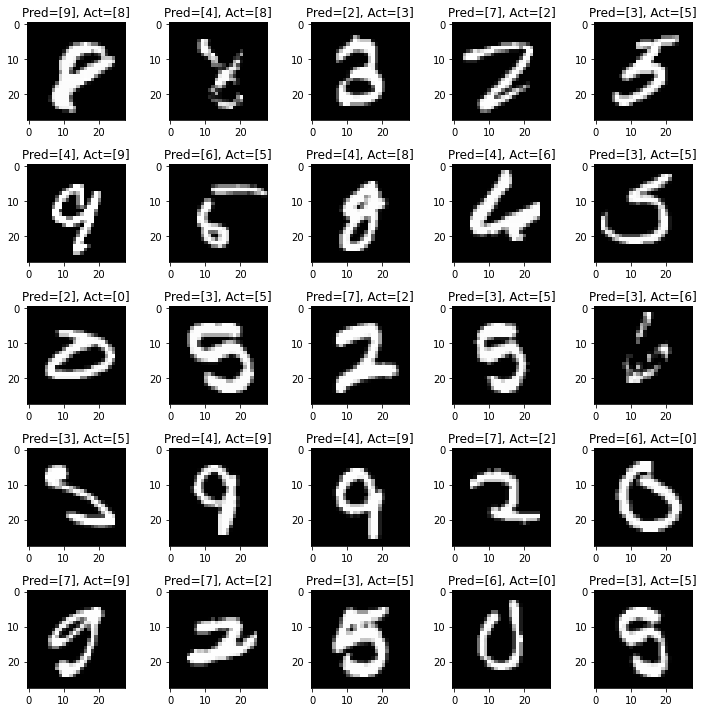

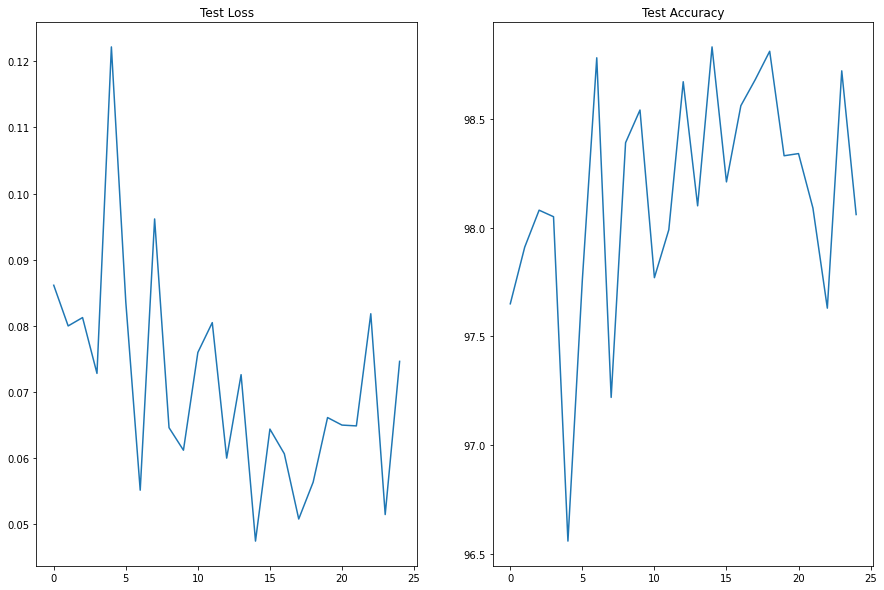

In [38]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, optimizer=l2_regulizer)

    bn_misclassifiedL2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedL2)

    bn_test_with_L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L2_Loss, bn_test_with_L2_acc)

**BN WITH L1L2**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/1875 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Train Set: Train Loss=0.3664189875125885 Batch_id=1874 Accuracy=92.68: 100%|██████████| 1875/1875 [01:07<00:00, 27.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  312

Test set: Average loss: 0.1180, Accuracy: 9688/10000 (96.88%)

EPOCH: 2


Train Set: Train Loss=0.31219738721847534 Batch_id=1874 Accuracy=96.21: 100%|██████████| 1875/1875 [01:08<00:00, 27.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  257

Test set: Average loss: 0.0984, Accuracy: 9743/10000 (97.43%)

EPOCH: 3


Train Set: Train Loss=0.22808299958705902 Batch_id=1874 Accuracy=96.42: 100%|██████████| 1875/1875 [01:07<00:00, 27.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  269

Test set: Average loss: 0.1066, Accuracy: 9731/10000 (97.31%)

EPOCH: 4


Train Set: Train Loss=0.19984948635101318 Batch_id=1874 Accuracy=96.41: 100%|██████████| 1875/1875 [01:07<00:00, 27.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  296

Test set: Average loss: 0.1056, Accuracy: 9704/10000 (97.04%)

EPOCH: 5


Train Set: Train Loss=0.29609963297843933 Batch_id=1874 Accuracy=96.45: 100%|██████████| 1875/1875 [01:07<00:00, 27.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  313

Test set: Average loss: 0.1141, Accuracy: 9687/10000 (96.87%)

EPOCH: 6


Train Set: Train Loss=0.24459756910800934 Batch_id=1874 Accuracy=96.37: 100%|██████████| 1875/1875 [01:08<00:00, 27.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  235

Test set: Average loss: 0.0912, Accuracy: 9765/10000 (97.65%)

EPOCH: 7


Train Set: Train Loss=0.4822744131088257 Batch_id=1874 Accuracy=96.31: 100%|██████████| 1875/1875 [01:09<00:00, 27.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  186

Test set: Average loss: 0.0773, Accuracy: 9814/10000 (98.14%)

EPOCH: 8


Train Set: Train Loss=0.41276660561561584 Batch_id=1874 Accuracy=96.40: 100%|██████████| 1875/1875 [01:08<00:00, 27.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  237

Test set: Average loss: 0.0995, Accuracy: 9763/10000 (97.63%)

EPOCH: 9


Train Set: Train Loss=0.34093618392944336 Batch_id=1874 Accuracy=96.51: 100%|██████████| 1875/1875 [01:08<00:00, 27.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  338

Test set: Average loss: 0.1240, Accuracy: 9662/10000 (96.62%)

EPOCH: 10


Train Set: Train Loss=0.24576473236083984 Batch_id=1874 Accuracy=96.48: 100%|██████████| 1875/1875 [01:07<00:00, 27.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  197

Test set: Average loss: 0.0898, Accuracy: 9803/10000 (98.03%)

EPOCH: 11


Train Set: Train Loss=0.2026253640651703 Batch_id=1874 Accuracy=96.49: 100%|██████████| 1875/1875 [01:08<00:00, 27.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  198

Test set: Average loss: 0.0822, Accuracy: 9802/10000 (98.02%)

EPOCH: 12


Train Set: Train Loss=0.2109733670949936 Batch_id=1874 Accuracy=96.47: 100%|██████████| 1875/1875 [01:07<00:00, 27.69it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  257

Test set: Average loss: 0.0984, Accuracy: 9743/10000 (97.43%)

EPOCH: 13


Train Set: Train Loss=0.24435119330883026 Batch_id=1874 Accuracy=96.53: 100%|██████████| 1875/1875 [01:07<00:00, 27.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  200

Test set: Average loss: 0.0927, Accuracy: 9800/10000 (98.00%)

EPOCH: 14


Train Set: Train Loss=0.5464562177658081 Batch_id=1874 Accuracy=96.48: 100%|██████████| 1875/1875 [01:08<00:00, 27.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  295

Test set: Average loss: 0.1150, Accuracy: 9705/10000 (97.05%)

EPOCH: 15


Train Set: Train Loss=0.3322031497955322 Batch_id=1874 Accuracy=96.43: 100%|██████████| 1875/1875 [01:09<00:00, 27.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  235

Test set: Average loss: 0.0931, Accuracy: 9765/10000 (97.65%)

EPOCH: 16


Train Set: Train Loss=0.2942426800727844 Batch_id=1874 Accuracy=96.60: 100%|██████████| 1875/1875 [01:08<00:00, 27.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  315

Test set: Average loss: 0.1127, Accuracy: 9685/10000 (96.85%)

EPOCH: 17


Train Set: Train Loss=0.28935813903808594 Batch_id=1874 Accuracy=96.33: 100%|██████████| 1875/1875 [01:08<00:00, 27.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  217

Test set: Average loss: 0.0824, Accuracy: 9783/10000 (97.83%)

EPOCH: 18


Train Set: Train Loss=0.25566378235816956 Batch_id=1874 Accuracy=96.48: 100%|██████████| 1875/1875 [01:07<00:00, 27.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  242

Test set: Average loss: 0.0925, Accuracy: 9758/10000 (97.58%)

EPOCH: 19


Train Set: Train Loss=0.20272095501422882 Batch_id=1874 Accuracy=96.53: 100%|██████████| 1875/1875 [01:07<00:00, 27.77it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  290

Test set: Average loss: 0.1086, Accuracy: 9710/10000 (97.10%)

EPOCH: 20


Train Set: Train Loss=0.29474350810050964 Batch_id=1874 Accuracy=96.44: 100%|██████████| 1875/1875 [01:07<00:00, 27.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  257

Test set: Average loss: 0.1010, Accuracy: 9743/10000 (97.43%)

EPOCH: 21


Train Set: Train Loss=0.27022016048431396 Batch_id=1874 Accuracy=96.50: 100%|██████████| 1875/1875 [01:08<00:00, 27.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  217

Test set: Average loss: 0.0896, Accuracy: 9783/10000 (97.83%)

EPOCH: 22


Train Set: Train Loss=0.1819142997264862 Batch_id=1874 Accuracy=96.54: 100%|██████████| 1875/1875 [01:08<00:00, 27.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  280

Test set: Average loss: 0.1046, Accuracy: 9720/10000 (97.20%)

EPOCH: 23


Train Set: Train Loss=0.23242118954658508 Batch_id=1874 Accuracy=96.46: 100%|██████████| 1875/1875 [01:09<00:00, 26.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  220

Test set: Average loss: 0.0843, Accuracy: 9780/10000 (97.80%)

EPOCH: 24


Train Set: Train Loss=0.3486211895942688 Batch_id=1874 Accuracy=96.42: 100%|██████████| 1875/1875 [01:09<00:00, 26.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

Number of miscalssified Images =  311

Test set: Average loss: 0.1128, Accuracy: 9689/10000 (96.89%)

EPOCH: 25


Train Set: Train Loss=0.2651606500148773 Batch_id=1874 Accuracy=96.49: 100%|██████████| 1875/1875 [01:08<00:00, 27.49it/s]


Number of miscalssified Images =  183

Test set: Average loss: 0.0795, Accuracy: 9817/10000 (98.17%)



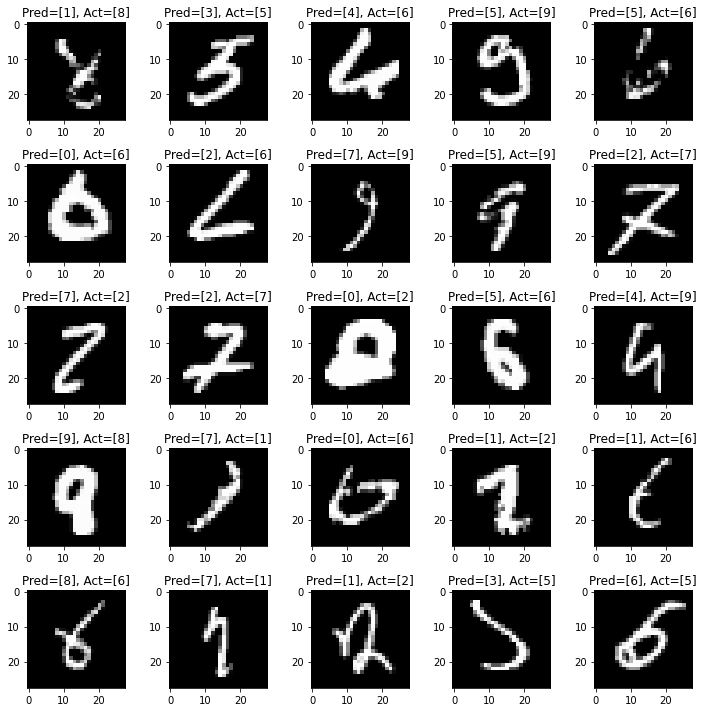

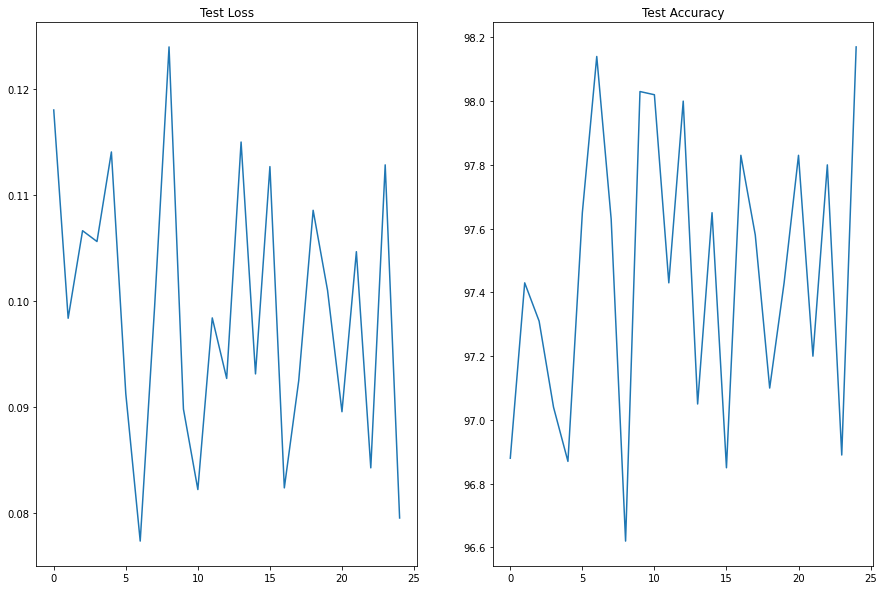

In [39]:
 with TrainTestUtils() as utils_obj:
    obj1 = Net()
    device = utils_obj.get_device()
    model =  obj1.to(device)
    l2_regulizer  =  utils_obj.apply_l2_regularizer(model, 0.005)

    # utils_obj.display_summary(model, 28)

    utils_obj.train_test_model(model, EPOCHS=EPOCHS, batch_size=BN_BATCHSIZE, l1_factor=0.0005, optimizer=l2_regulizer)

    bn_misclassifiedL1L2.extend(utils_obj.misclassifiedImages)
    utils_obj.plot_misclassified(bn_misclassifiedwithoutL1L2)

    bn_test_with_L1L2_Loss.extend(utils_obj.test_losses)
    bn_test_with_L1L2_acc.extend(utils_obj.test_acc)

    utils_obj.plot_test_loss_acc(bn_test_with_L1L2_Loss, bn_test_with_L1L2_acc)

**SHOW LOSS AND ACCURACY GRAPHS**

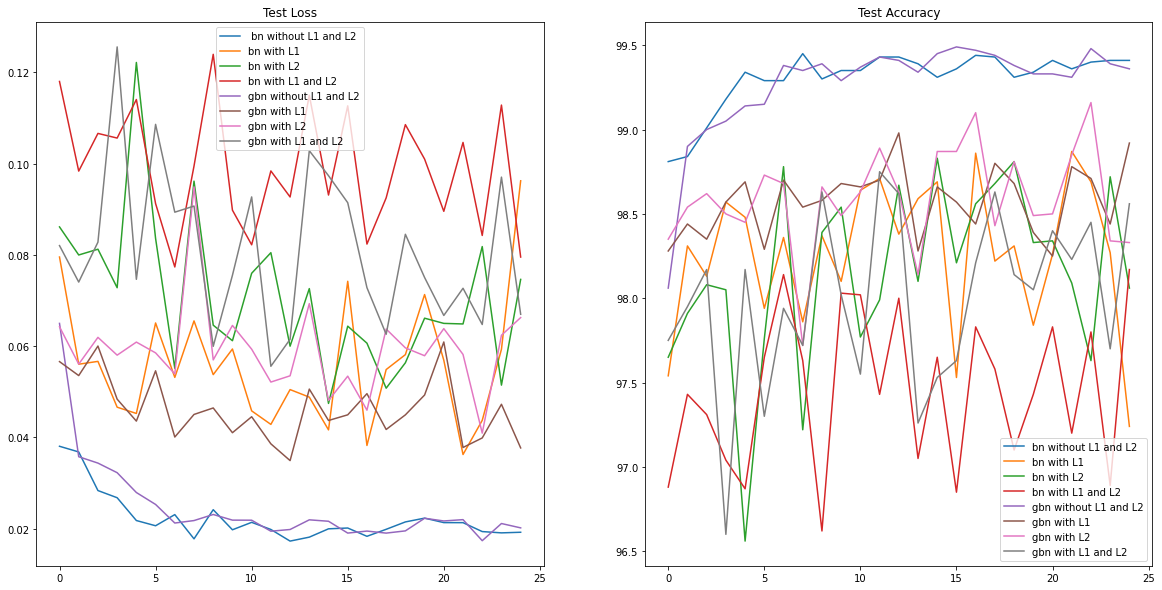

In [40]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(bn_test_without_L1L2_Loss, label=' bn without L1 and L2')
axs[0].plot(bn_test_with_L1_Loss, label='bn with L1 ')
axs[0].plot(bn_test_with_L2_Loss, label='bn with L2 ')
axs[0].plot(bn_test_with_L1L2_Loss, label='bn with L1 and L2 ')

axs[0].plot(gbn_test_without_L1L2_Loss, label='gbn without L1 and L2')
axs[0].plot(gbn_test_with_L1_Loss, label='gbn with L1 ')
axs[0].plot(gbn_test_with_L2_Loss, label='gbn with L2 ')
axs[0].plot(gbn_test_with_L1L2_Loss, label='gbn with L1 and L2 ')

axs[0].set_title("Test Loss")

axs[0].legend()

axs[1].plot(bn_test_without_L1L2_acc, label='bn without L1 and L2')
axs[1].plot(bn_test_with_L1_acc, label='bn with L1 ')
axs[1].plot(bn_test_with_L2_acc, label='bn with L2')
axs[1].plot(bn_test_with_L1L2_acc, label='bn with L1 and L2 ')

axs[1].plot(gbn_test_without_L1L2_acc, label='gbn without L1 and L2')
axs[1].plot(gbn_test_with_L1_acc, label='gbn with L1 ')
axs[1].plot(gbn_test_with_L2_acc, label='gbn with L2')
axs[1].plot(gbn_test_with_L1L2_acc, label='gbn with L1 and L2 ')

axs[1].set_title("Test Accuracy")
axs[1].legend()